### Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import Optimizer
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import math


### Load Data

In [2]:
batch_size = 100
# CIFAR10 Dataset
train_dataset = datasets.CIFAR10(root='./data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.CIFAR10(root='./data/', train=False, transform=transforms.ToTensor(), download=True)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


### Variational AutoEncoder

In [3]:
class VAE(nn.Module):
    def __init__(self,h_dim, z_dim):
        super(VAE, self).__init__()
        
        # encoder part
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(32, 48, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(48)

        self.fc1 = nn.Linear(8 * 8 * 48, h_dim)
        self.fc_bn1 = nn.BatchNorm1d(h_dim)
        self.fc21 = nn.Linear(h_dim, z_dim)
        self.fc22 = nn.Linear(h_dim, z_dim)
        
        
        
        
        #self.fc1 = nn.Linear(x_dim, h_dim1)
        #self.fc2 = nn.Linear(h_dim1, h_dim2)
        #self.fc31 = nn.Linear(h_dim2, z_dim)
        #self.fc32 = nn.Linear(h_dim2, z_dim)
        
        
        # decoder part
        self.fc3 = nn.Linear(z_dim, h_dim)
        self.fc_bn3 = nn.BatchNorm1d(h_dim)
        self.fc4 = nn.Linear(h_dim, 8 * 8 * 48)
        self.fc_bn4 = nn.BatchNorm1d(8 * 8 * 48)

        self.pixel_shuffle = nn.PixelShuffle(4)
        #self.conv5 = nn.ConvTranspose2d(16, 32, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        #self.bn5 = nn.BatchNorm2d(32)
        #self.conv6 = nn.ConvTranspose2d(32, 32, kernel_size=3, stride=1, padding=1, bias=False)
        #self.bn6 = nn.BatchNorm2d(32)
        #self.conv7 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        #self.bn7 = nn.BatchNorm2d(16)
        #self.conv8 = nn.ConvTranspose2d(16, 3, kernel_size=3, stride=1, padding=1, bias=False)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.softplus = nn.Softplus()
        
        
        #self.fc4 = nn.Linear(z_dim, h_dim2)
        #self.fc5 = nn.Linear(h_dim2, h_dim1)
        #self.fc6 = nn.Linear(h_dim1, x_dim)
        
    def encoder(self, x):
        conv1 = self.relu(self.bn1(self.conv1(x)))
        conv2 = self.relu(self.bn2(self.conv2(conv1)))
        conv3 = self.relu(self.bn3(self.conv3(conv2)))
        conv4 = self.relu(self.bn4(self.conv4(conv3))).view(-1, 8 * 8 * 48)
        fc1 = self.relu(self.fc_bn1(self.fc1(conv4)))
        return self.fc21(fc1), self.softplus(self.fc22(fc1))
        #h = F.relu(self.fc1(x))
        #h = F.relu(self.fc2(h))
        #return self.fc31(h), self.fc32(h) # mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
    def decoder(self, z):
        fc3 = self.relu(self.fc_bn3(self.fc3(z)))
        fc4 = self.relu(self.fc_bn4(self.fc4(fc3))).view(-1, 48, 8, 8)

        #conv5 = self.relu(self.bn5(self.conv5(fc4)))
        #conv6 = self.relu(self.bn6(self.conv6(conv5)))
        #conv7 = self.relu(self.bn7(self.conv7(conv6)))
        pixelshuffle = self.sigmoid(self.pixel_shuffle(fc4))
        return pixelshuffle.view(-1, 3, 32, 32)
        #h = F.relu(self.fc4(z))
        #h = F.relu(self.fc5(h))
        #return F.sigmoid(self.fc6(h)) 
    
    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

# build model
vae = VAE(h_dim= 512, z_dim=512)
if torch.cuda.is_available():
    vae.cuda()

In [4]:
vae

VAE(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(32, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=3072, out_features=512, bias=True)
  (fc_bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc21): Linear(in_features=512, out_features=512, bias=True)
  (fc22): Linear(in_features=512, out_features=512, bias=True)
  

### Optmizer and Loss Function

In [5]:
#optimizer = optim.Adam(vae.parameters())


class MyADAM(Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.99), eps=1e-8, weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        super(MyADAM, self).__init__(params, defaults)
        
    def step(self):
        """
        Performs a single optimization step.
        """
        loss = None
        for group in self.param_groups:
            for p in group['params']:
                grad = p.grad.data
                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p.data)
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                
                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']

                b1, b2 = group['betas']
                state['step'] += 1
                
                # L2
                if group['weight_decay'] != 0:
                    grad = grad.add(group['weight_decay'], p.data)

                # Momentum
                exp_avg = torch.mul(exp_avg, b1) + (1 - b1)*grad
                
                # RMS
                exp_avg_sq = torch.mul(exp_avg_sq, b2) + (1-b2)*(grad*grad)
                
                denom = exp_avg_sq.sqrt() + group['eps']

                bias_correction1 = 1 / (1 - b1 ** state['step'])
                bias_correction2 = 1 / (1 - b2 ** state['step'])
                
                adapted_learning_rate = group['lr'] * bias_correction1 / math.sqrt(bias_correction2)

                p.data = p.data - adapted_learning_rate * exp_avg / denom 
                
                
        return loss

optimizer = MyADAM(vae.parameters())

# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

### Training

In [6]:
def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        # add noise to image 
        data_n = torch.mul(data+0.25, 0.1 * torch.rand(batch_size,3,32,32))
        if torch.cuda.is_available():
            data = data.cuda()
            data_n = data_n.cuda()
        
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = vae(data_n)
        loss = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

In [7]:
import matplotlib.pyplot as plt
def test():
    vae.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in test_loader:
            if torch.cuda.is_available():
                data = data.cuda()
            recon, mu, log_var = vae(data)
            
            # sum up batch loss
            test_loss += loss_function(recon, data, mu, log_var).item()
        
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [8]:
for epoch in range(1, 11):
    train(epoch)
    test()

Train Epoch: 1 [0/50000 (0%)]	Loss: 2485.877969
Train Epoch: 1 [10000/50000 (20%)]	Loss: 2077.579688
Train Epoch: 1 [20000/50000 (40%)]	Loss: 2070.477031
Train Epoch: 1 [30000/50000 (60%)]	Loss: 2061.352500
Train Epoch: 1 [40000/50000 (80%)]	Loss: 2023.948125
====> Epoch: 1 Average loss: 2069.0793
====> Test set loss: 235307.7926
Train Epoch: 2 [0/50000 (0%)]	Loss: 2061.764062
Train Epoch: 2 [10000/50000 (20%)]	Loss: 2043.062813
Train Epoch: 2 [20000/50000 (40%)]	Loss: 2019.438750
Train Epoch: 2 [30000/50000 (60%)]	Loss: 2039.844531
Train Epoch: 2 [40000/50000 (80%)]	Loss: 2046.274375
====> Epoch: 2 Average loss: 2038.1670
====> Test set loss: 180397.1318
Train Epoch: 3 [0/50000 (0%)]	Loss: 1997.994062
Train Epoch: 3 [10000/50000 (20%)]	Loss: 2066.772812
Train Epoch: 3 [20000/50000 (40%)]	Loss: 2054.325313
Train Epoch: 3 [30000/50000 (60%)]	Loss: 2033.640312
Train Epoch: 3 [40000/50000 (80%)]	Loss: 2061.254063
====> Epoch: 3 Average loss: 2034.4046
====> Test set loss: 215993.5642
Trai

### View Results

In [9]:
import IPython,os

with torch.no_grad():
    z = torch.randn(64, 512).cuda()
    sample = vae.decoder(z).cuda()
    
    
    save_image(sample.view(64, 3, 32, 32), './samples/sample_' + '.png')

--------------------------./samples-------------------------
sample_.png


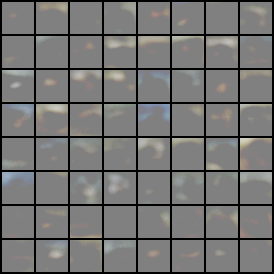

In [10]:
from PIL import Image
import os, os.path
import IPython

imgs = []
paths = ["./samples"]
for path in paths:
    print("--------------------------"+path+"-------------------------")
    valid_images = [".png"]
    for f in os.listdir(path):
        ext = os.path.splitext(f)[1]
        if ext.lower() not in valid_images:
            continue
        print(f)
        display(IPython.display.Image(os.path.join(path,f),width=900))

### Classification

In [32]:
'''
STEP 1: LOADING DATASET
'''

dataset = datasets.CIFAR10('./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.CIFAR10('./data', train=False, download=True, transform=transforms.ToTensor())
CLASSES = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

'''
STEP 2: SPLIT DATA TO TRAINING AND VALIDATION
'''
#validation set size 5000 
val_size = 5000
train_size = len(dataset) - val_size

#creating training & validation set using random_split
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
len(train_dataset), len(val_dataset)

'''
STEP 3: MAKING DATASET ITERABLE
'''
#Creating data loader to load data in batches
batch_size=100
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size*2, num_workers=4, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size*2, num_workers=4, pin_memory=True)

'''
Step 4 : Creat Model class
'''

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))



class VAE_Classification(nn.Module):
    def __init__(self,h_dim, z_dim):
        super(VAE_Classification, self).__init__()
        
        # encoder part
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(32, 48, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(48)

        self.fc1 = nn.Linear(8 * 8 * 48, h_dim)
        self.fc_bn1 = nn.BatchNorm1d(h_dim)
        self.fc21 = nn.Linear(h_dim, z_dim)
        self.fc22 = nn.Linear(h_dim, z_dim)
        
        self.fc23 = nn.Linear(z_dim*2, 10)
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.softplus = nn.Softplus()
        
    def encoder(self, x):
        conv1 = self.relu(self.bn1(self.conv1(x)))
        conv2 = self.relu(self.bn2(self.conv2(conv1)))
        conv3 = self.relu(self.bn3(self.conv3(conv2)))
        conv4 = self.relu(self.bn4(self.conv4(conv3))).view(-1, 8 * 8 * 48)
        fc1 = self.relu(self.fc_bn1(self.fc1(conv4)))
        return self.fc21(fc1), self.softplus(self.fc22(fc1))
        #h = F.relu(self.fc1(x))
        #h = F.relu(self.fc2(h))
        #return self.fc31(h), self.fc32(h) # mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
    
    def forward(self, x):
        mu, log_var = self.encoder(x)
        result=torch.cat((mu, log_var),dim=1)
        print("Shape of result",result.shape)
        return self.fc23(mu)
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = torch.nn.functional.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = torch.nn.functional.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

input_size = 3*32*32
output_size = 10
model = VAE_Classification(h_dim= 512, z_dim=512)


def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

'''
Step 5: Move model and data to GPU if availble 
'''

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)
def __len__(self):
        """Number of batches"""
        return len(self.dl)
    
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

model = to_device(model, device)

'''
Step 5: Train Model
'''
history = [evaluate(model, val_loader)]
history # initial Loss and accuracy
history += fit(25, 0.06, model, train_loader, val_loader)

Files already downloaded and verified
Files already downloaded and verified
Shape of result torch.Size([200, 1024])


RuntimeError: mat1 dim 1 must match mat2 dim 0

In [ ]:
evaluate(model, test_loader) # its displayed as validation loss and accuracy, but this is the test loss